In [1]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

%load_ext autoreload
%autoreload 2

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19



In [2]:
#df_rki = cov19.data_retrieval.get_rki()
import pickle
#pickle.dump(df_rki, open('df_rki.pickled', 'wb'))
df_rki = pickle.load(open('df_rki.pickled', 'rb'))

In [108]:
df_bundeslaender = cov19.filter_rki_all_bundesland(df_rki, '2020-03-10', '2020-03-25')
new_cases_obs = np.diff(np.array(df_bundeslaender),axis=0)[:,:]


date_begin_data = datetime.datetime(2020,3,10)
date_end_data   = datetime.datetime(2020,3,25)
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]

In [135]:
params_model = dict(new_cases_obs = new_cases_obs,
                    date_begin_data = date_begin_data,
                    num_days_forecast = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) # normally one would put here an array with the number of inhabitants of 
                                         # of each state

with cov19.Cov19_Model(**params_model) as model:
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = [])
    
    new_I_t = cov19.SIR(lambda_t_log)
    
    new_cases_inferred_raw = cov19.delay_cases(new_I_t)
    
    #new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    cov19.student_t_likelihood(new_cases_inferred_raw)


In [136]:
trace = pm.sample(model=model, init='advi+adapt_diag', tune=500, draws=500)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 1,299.8:  18%|█▊        | 36375/200000 [02:22<10:38, 256.07it/s]
Convergence achieved at 36400
Interrupted at 36,399 [18%]: Average Loss = 1,523.5
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_obs, scale_delay_L2_raw, scale_delay_L1, sigma_scale_delay_L2, delay_L2_raw, delay_L1, sigma_delay_L2, I_begin, mu, lambda_0_L2_raw, lambda_0_L1, sigma_lambda_0_L2]
Sampling 2 chains, 15 divergences: 100%|██████████| 600/600 [01:41<00:00,  5.93draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 25% for some parameters.


Dimension of lambda_0_L2_raw larger than one, skipping
Dimension of I_begin larger than one, skipping
Dimension of delay_L2_raw larger than one, skipping
Dimension of scale_delay_L2_raw larger than one, skipping
Dimension of sigma_obs larger than one, skipping


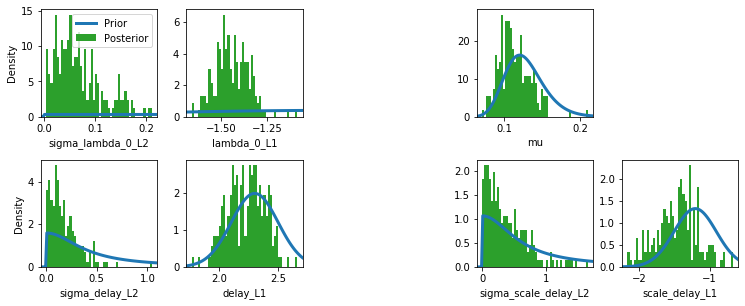

In [137]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)
